# Modeling and Simulation in Python

Chapter 25

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Teapots and Turntables

Tables in Chinese restaurants often have a rotating tray or turntable that makes it easy for customers to share dishes.  These turntables are supported by low-friction bearings that allow them to turn easily and glide.  However, they can be heavy, especially when they are loaded with food, so they have a high moment of inertia.

Suppose I am sitting at a table with a pot of tea on the turntable directly in front of me, and the person sitting directly opposite asks me to pass the tea.  I push on the edge of the turntable with 1 Newton of force until it has turned 0.5 radians, then let go.  The turntable glides until it comes to a stop 1.5 radians from the starting position.  How much force should I apply for a second push so the teapot glides to a stop directly opposite me?

The following figure shows the scenario, where `F` is the force I apply to the turntable at the perimeter, perpendicular to the moment arm, `r`, and `tau` is the resulting torque.  The blue circle near the bottom is the teapot.

![](diagrams/teapot.png)

We'll answer this question in these steps:

1.  We'll use the results from the first push to estimate the coefficient of friction for the turntable.

2.  We'll use that coefficient of friction to estimate the force needed to rotate the turntable through the remaining angle.

Our simulation will use the following parameters:

1.  The radius of the turntable is 0.5 meters, and its weight is 7 kg.

2.  The teapot weights 0.3 kg, and it sits 0.4 meters from the center of the turntable.

As usual, I'll get units from Pint.

In [2]:
radian = UNITS.radian
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newton

<Unit('newton')>

And store the parameters in a `Params` object.

In [3]:
params = Params(radius_disk=0.5*m,
                mass_disk=7*kg,
                radius_pot=0.4*m,
                mass_pot=0.3*kg,
                force=1*N,
                torque_friction=0.2*N*m,
                theta_end=0.5*radian,
                t_end=20*s)

,values
radius_disk,0.5 meter
mass_disk,7 kilogram
radius_pot,0.4 meter
mass_pot,0.3 kilogram
force,1 newton
torque_friction,0.2 meter * newton
theta_end,0.5 radian
t_end,20 second


`make_system` creates the initial state, `init`, and computes the total moment of inertia for the turntable and the teapot.

In [4]:
def make_system(params):
    """Make a system object.
    
    params: Params object
    
    returns: System object
    """
    mass_disk, mass_pot = params.mass_disk, params.mass_pot
    radius_disk, radius_pot = params.radius_disk, params.radius_pot
    
    init = State(theta=0*radian, omega=0*radian/s)
    
    I_disk = mass_disk * radius_disk**2 / 2
    I_pot = mass_pot * radius_pot**2
    
    return System(params, init=init, I=I_disk+I_pot)

Here's the `System` object we'll use for the first phase of the simulation, while I am pushing the turntable.

In [5]:
system1 = make_system(params)

,values
radius_disk,0.5 meter
mass_disk,7 kilogram
radius_pot,0.4 meter
mass_pot,0.3 kilogram
force,1 newton
torque_friction,0.2 meter * newton
theta_end,0.5 radian
t_end,20 second
init,theta 0 radian omega 0.0 radi...
I,0.923 kilogram * meter ** 2


### Simulation

When I stop pushing on the turntable, the angular acceleration changes abruptly.  We could implement the slope function with an `if` statement that checks the value of `theta` and sets `force` accordingly.  And for a coarse model like this one, that might be fine.  But we will get more accurate results if we simulate the system in two phases:

1.  During the first phase, force is constant, and we run until `theta` is 0.5 radians.

2.  During the second phase, force is 0, and we run until `omega` is 0.

Then we can combine the results of the two phases into a single `TimeFrame`.

Here's the slope function we'll use:

In [6]:
def slope_func(state, t, system):
    """Computes the derivatives of the state variables.
    
    state: State object
    t: time
    system: System object 
    
    returns: sequence of derivatives
    """
    theta, omega = state
    radius_disk, force = system.radius_disk, system.force
    torque_friction, I = system.torque_friction, system.I
    
    torque = radius_disk * force - torque_friction
    alpha = torque / I
    
    return omega, alpha 

As always, we'll test the slope function before running the simulation.

In [7]:
slope_func(system1.init, 0, system1)

(0.0 <Unit('radian / second')>,
 0.32502708559046584 <Unit('newton / kilogram / meter')>)

Here's an event function that stops the simulation when `theta` reaches `theta_end`.

In [8]:
def event_func1(state, t, system):
    """Stops when theta reaches theta_end.
    
    state: State object
    t: time
    system: System object 
    
    returns: difference from target
    """
    theta, omega = state
    return theta - system.theta_end 

In [9]:
event_func1(system1.init, 0, system1)

-0.5 <Unit('radian')>

Now we can run the first phase.

In [10]:
results1, details1 = run_ode_solver(system1, slope_func, events=event_func1)
details1

,values
success,True
message,A termination event occurred.


And look at the results.

In [11]:
results1.tail()

,theta,omega
1.000000,0.16251354279523292 radian,0.32502708559046584 radian / second
1.200000,0.2340195016251354 radian,0.390032502708559 radian / second
1.400000,0.31852654387865653 radian,0.45503791982665215 radian / second
1.600000,0.41603466955579627 radian,0.5200433369447454 radian / second
1.751961,0.5 radian,0.569434707794277 radian / second


### Phase 2

Before we run the second phase, we have to extract the final time and state of the first phase.

In [12]:
t_0 = results1.last_label() * s

1.7519607843137255 <Unit('second')>

And make an initial `State` object for Phase 2.

In [13]:
init2 = results1.last_row()

,values
theta,0.5 radian
omega,0.569434707794277 radian / second


And a new `System` object with zero force.

In [14]:
system2 = System(system1, t_0=t_0, init=init2, force=0*N)

,values
radius_disk,0.5 meter
mass_disk,7 kilogram
radius_pot,0.4 meter
mass_pot,0.3 kilogram
force,0 newton
torque_friction,0.2 meter * newton
theta_end,0.5 radian
t_end,20 second
init,theta 0.5 radian ome...
I,0.923 kilogram * meter ** 2


Here's an event function that stops when angular velocity is 0.

In [15]:
def event_func2(state, t, system):
    """Stops when omega is 0.
    
    state: State object
    t: time
    system: System object 
    
    returns: omega
    """
    theta, omega = state
    return omega

In [16]:
event_func2(system2.init, 0, system2)

0.569434707794277 <Unit('radian / second')>

Now we can run the second phase.

In [17]:
slope_func(system2.init, system2.t_0, system2)

(0.569434707794277 <Unit('radian / second')>,
 -0.21668472372697725 <Unit('newton / kilogram / meter')>)

In [18]:
results2, details2 = run_ode_solver(system2, slope_func, events=event_func2)
details2

,values
success,True
message,A termination event occurred.


And check the results.

In [19]:
results2.tail()

,theta,omega
3.751961,1.2054999681345993 radian,0.13606526034032235 radian / second
3.951961,1.2283793257281241 radian,0.09272831559492689 radian / second
4.151961,1.2425912943725699 radian,0.049391370849531435 radian / second
4.351961,1.2481358740679367 radian,0.006054426104135979 radian / second
4.379902,1.247699599245727 radian,0.0 radian / second


Pandas provides `combine_first`, which combines `results1` and `results2`.

In [20]:
results = results1.combine_first(results2)
results.tail()

,theta,omega
3.751961,1.2054999681345993 radian,0.13606526034032235 radian / second
3.951961,1.2283793257281241 radian,0.09272831559492689 radian / second
4.151961,1.2425912943725699 radian,0.049391370849531435 radian / second
4.351961,1.2481358740679367 radian,0.006054426104135979 radian / second
4.379902,1.247699599245727 radian,0.0 radian / second


Now we can plot `theta` for both phases.

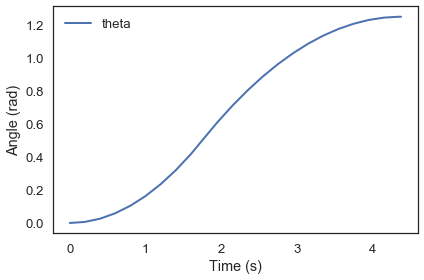

In [21]:
def plot_theta(results):
    plot(results.theta, label='theta')
    decorate(xlabel='Time (s)',
             ylabel='Angle (rad)')
    
plot_theta(results)

And `omega`.

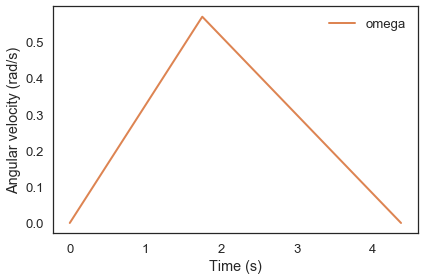

In [22]:
def plot_omega(results):
    plot(results.omega, label='omega', color='C1')
    decorate(xlabel='Time (s)',
             ylabel='Angular velocity (rad/s)')
    
plot_omega(results)

Saving figure to file figs/chap25-fig01.pdf


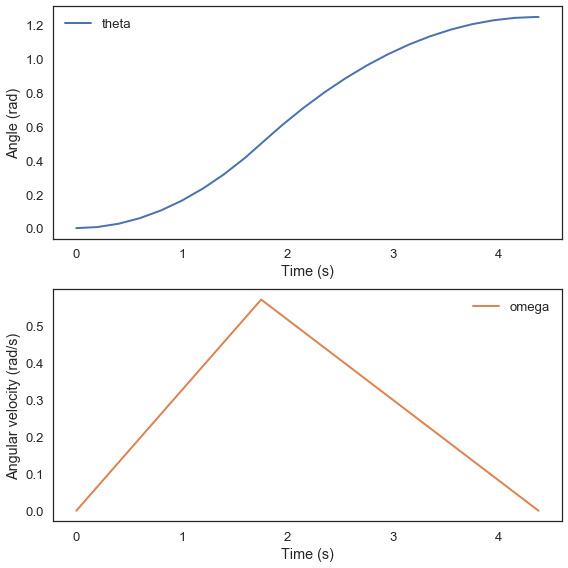

In [23]:
subplot(2, 1, 1)
plot_theta(results)
subplot(2, 1, 2)
plot_omega(results)
savefig('figs/chap25-fig01.pdf')

### Estimating friction

Let's take the code from the previous section and wrap it in a function.

In [24]:
def run_two_phases(force, torque_friction, params):
    """Run both phases.
    
    force: force applied to the turntable
    torque_friction: friction due to torque
    params: Params object
    
    returns: TimeFrame of simulation results
    """
    # put the specified parameters into the Params object
    params = Params(params, force=force, torque_friction=torque_friction)

    # run phase 1
    system1 = make_system(params)
    results1, details1 = run_ode_solver(system1, slope_func, 
                                          events=event_func1)

    # get the final state from phase 1
    t_0 = results1.last_label() * s
    init2 = results1.last_row()
    
    # run phase 2
    system2 = System(system1, t_0=t_0, init=init2, force=0*N)
    results2, details2 = run_ode_solver(system2, slope_func, 
                                        events=event_func2)
    
    # combine and return the results
    results = results1.combine_first(results2)
    return TimeFrame(results)

Let's test it with the same parameters.

In [25]:
force = 1*N
torque_friction = 0.2*N*m
results = run_two_phases(force, torque_friction, params)
results.tail()

,theta,omega
3.751961,1.2054999681345993 radian,0.13606526034032235 radian / second
3.951961,1.2283793257281241 radian,0.09272831559492689 radian / second
4.151961,1.2425912943725699 radian,0.049391370849531435 radian / second
4.351961,1.2481358740679367 radian,0.006054426104135979 radian / second
4.379902,1.247699599245727 radian,0.0 radian / second


And check the results.

In [26]:
theta_final = results.last_row().theta

1.247699599245727 <Unit('radian')>

Here's the error function we'll use with `root_bisect`.

It takes a hypothetical value for `torque_friction` and returns the difference between `theta_final` and the observed duration of the first push, 1.5 radian.

In [27]:
def error_func1(torque_friction, params):
    """Error function for root_scalar.
    
    torque_friction: hypothetical value
    params: Params object
    
    returns: offset from target value
    """
    force = 1 * N
    results = run_two_phases(force, torque_friction, params)
    theta_final = results.last_row().theta
    print(torque_friction, theta_final)
    return theta_final - 1.5 * radian

Testing the error function.

In [28]:
guess1 = 0.1*N*m
error_func1(guess1, params)

0.1 meter * newton 2.491081016010591 radian


0.991081016010591 <Unit('radian')>

In [29]:
guess2 = 0.3*N*m
error_func1(guess2, params)

0.3 meter * newton 0.8319164068661051 radian


-0.6680835931338949 <Unit('radian')>

And running `root_scalar`.

In [30]:
res = root_bisect(error_func1, [guess1, guess2], params)

0.1 meter * newton 2.491081016010591 radian
0.3 meter * newton 0.8319164068661051 radian
0.2 meter * newton 1.247699599245727 radian
0.15000000000000002 meter * newton 1.664679140408952 radian
0.17500000000000002 meter * newton 1.4245119372074873 radian
0.16250000000000003 meter * newton 1.5351133644066652 radian
0.16875 meter * newton 1.4775125382367449 radian
0.16562500000000002 meter * newton 1.5057134910749645 radian
0.16718750000000002 meter * newton 1.4913395920086545 radian
0.16640625000000003 meter * newton 1.4984572231242101 radian
0.16601562500000003 meter * newton 1.502067905168568 radian
0.16621093750000004 meter * newton 1.5002582165443015 radian
0.16630859375000004 meter * newton 1.4993566348484146 radian
0.16625976562500006 meter * newton 1.4998071542109142 radian
0.16623535156250005 meter * newton 1.500032617476343 radian
0.16624755859375007 meter * newton 1.499919868872052 radian
0.16624145507812504 meter * newton 1.4999762389308366 radian
0.16623840332031253 meter * n

,values
converged,True
root,0.16623888611793522 meter * newton


The result is the coefficient of friction that yields a total rotation of 1.5 radian.

In [31]:
torque_friction = res.root

0.16623888611793522 <Unit('meter * newton')>

Here's a test run with the estimated value.

In [32]:
force = 1 * N
results = run_two_phases(force, torque_friction, params)
theta_final = get_last_value(results.theta)

1.4999999675382056 <Unit('radian')>

Looks good.

### Animation


Here's a draw function we can use to animate the results.

In [33]:
from matplotlib.patches import Circle
from matplotlib.patches import Arrow

def draw_func(state, t):
    theta, omega = state
    
    # draw a circle for the table
    radius_disk = magnitude(params.radius_disk)
    circle1 = Circle([0, 0], radius_disk)
    plt.gca().add_patch(circle1)
    
    # draw a circle for the teapot
    radius_pot = magnitude(params.radius_pot)
    center = pol2cart(theta, radius_pot)
    circle2 = Circle(center, 0.05, color='C1')
    plt.gca().add_patch(circle2)

    # make the aspect ratio 1
    plt.axis('equal')

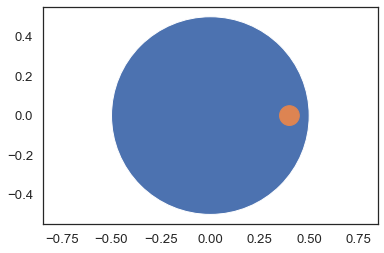

In [34]:
state = results.first_row()
draw_func(state, 0)

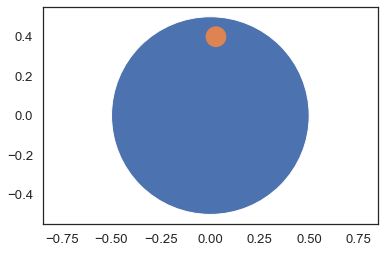

In [35]:
animate(results, draw_func)


### Exercises

Now finish off the example by estimating the force that delivers the teapot to the desired position.

Write an error function that takes `force` and `params` and returns the offset from the desired angle.

In [36]:
# Solution

def error_func2(force, params):
    """Error function for root_scalar.
    
    force: hypothetical value
    params: Params object
    
    returns: offset from target value
    """
    # notice that this function uses the global value of torque_friction
    results = run_two_phases(force, torque_friction, params)
    theta_final = get_last_value(results.theta)
    print(force, theta_final)
    remaining_angle = np.pi - 1.5
    return theta_final - remaining_angle * radian

Test the error function with `force=1`

In [37]:
# Solution

guess1 = 0.5 * N
error_func2(guess1, params)

0.5 newton 0.7508796257362771 radian


-0.890713027853516 <Unit('radian')>

In [38]:
# Solution

guess2 = 2 * N
error_func2(guess2, params)

2 newton 2.990287714114223 radian


1.3486950605244297 <Unit('radian')>

And run `root_bisect` to find the desired force.

In [39]:
# Solution

res = root_bisect(error_func2, [guess1, guess2], params)

0.5 newton 0.7508796257362771 radian
2 newton 2.990287714114223 radian
1.25 newton 1.8767666580336735 radian
0.875 newton 1.314142751543798 radian
1.0625 newton 1.5961003377501604 radian
1.15625 newton 1.7324316654000937 radian
1.109375 newton 1.6640846390801893 radian
1.0859375 newton 1.6295935099707282 radian
1.09765625 newton 1.6467143299143472 radian
1.091796875 newton 1.6381227337897593 radian
1.0947265625 newton 1.6424107353138588 radian
1.09326171875 newton 1.6402647854172603 radian
1.093994140625 newton 1.6413372730819231 radian
1.0943603515625 newton 1.6418738823769812 radian
1.09417724609375 newton 1.641605547274225 radian
1.094085693359375 newton 1.6414714025642667 radian
1.0941314697265625 newton 1.641538473015794 radian
1.0941543579101562 newton 1.6415720096691466 radian
1.0941658020019531 newton 1.6415887783527199 radian
1.0941715240478516 newton 1.6415971627837305 radian
1.0941686630249023 newton 1.6415929705607897 radian
1.0941672325134277 newton 1.641590874454896 radia

,values
converged,True
root,1.0941684395074844 newton


In [40]:
force = res.root
results = run_two_phases(force, torque_friction, params)
theta_final = get_last_value(results.theta)

1.6415926430439989 <Unit('radian')>

In [41]:
remaining_angle = np.pi - 1.5

1.6415926535897931

**Exercise:** Now suppose my friend pours 0.1 kg of tea and puts the teapot back on the turntable at distance 0.3 meters from the center.  If I ask for the tea back, how much force should they apply, over an arc of 0.5 radians, to make the teapot glide to a stop back in front of me?  You can assume that torque due to friction is proportional to the total mass of the teapot and the turntable.

In [42]:
# Solution

mass_before = params.mass_pot + params.mass_disk

7.3 <Unit('kilogram')>

In [43]:
# Solution

params2 = Params(params, mass_pot=0.2*kg, radius_pot=0.3*m)

,values
radius_disk,0.5 meter
mass_disk,7 kilogram
radius_pot,0.3 meter
mass_pot,0.2 kilogram
force,1 newton
torque_friction,0.2 meter * newton
theta_end,0.5 radian
t_end,20 second


In [44]:
# Solution

mass_after = params2.mass_pot + params2.mass_disk

7.2 <Unit('kilogram')>

In [45]:
# Solution

torque_friction

0.16623888611793522 <Unit('meter * newton')>

In [46]:
# Solution

torque_friction2 = torque_friction * mass_after / mass_before

0.16396164110262107 <Unit('meter * newton')>

In [47]:
# Solution

guess = 2 * N
results = run_two_phases(guess, torque_friction2, params2)
results.tail()

,theta,omega
5.630969,2.9973839879919186 radian,0.12061194274576453 radian / second
5.830969,3.0178342233248876 radian,0.0838904105839233 radian / second
6.030969,3.030940152225488 radian,0.04716887842208207 radian / second
6.230969,3.03670177469372 radian,0.010447346260240839 radian / second
6.287870,3.036251498073426 radian,0.0 radian / second


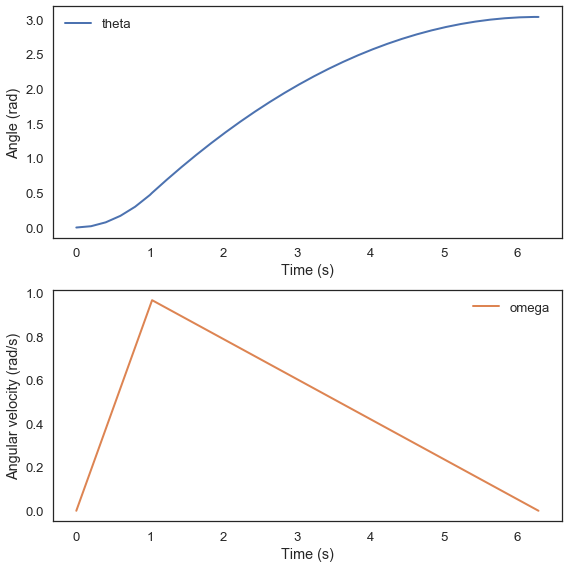

In [48]:
# Solution

subplot(2, 1, 1)
plot_theta(results)
subplot(2, 1, 2)
plot_omega(results)

In [49]:
# Solution

# Note: this is so similar to error_func2, it would be better
# to generalize it, but for expediency, I will make a modified
# verison.

def error_func3(force, params):
    """Error function for root_scalar.
    
    force: hypothetical value
    params: Params object
    
    returns: offset from target value
    """
    # notice that this function uses the global value of torque_friction2
    results = run_two_phases(force, torque_friction2, params)
    theta_final = get_last_value(results.theta)
    print(force, theta_final)
    remaining_angle = np.pi * radian
    return theta_final - remaining_angle

In [50]:
# Solution

guess1 = 1 * N
error_func3(guess1, params)

1 newton 1.521633703251964 radian


-1.619958950337829 <Unit('radian')>

In [51]:
# Solution

guess2 = 3 * N
error_func3(guess2, params)

3 newton 4.544952149083414 radian


1.4033594954936213 <Unit('radian')>

In [52]:
# Solution

res = root_bisect(error_func3, [guess1, guess2], params2)

1 newton 1.5220674118848017 radian
3 newton 4.555863285616827 radian
2.0 newton 3.036251498073426 radian
2.5 newton 3.7711230348952873 radian
2.25 newton 3.410270734411078 radian
2.125 newton 3.237449910464716 radian
2.0625 newton 3.137756144960873 radian
2.09375 newton 3.189525229335694 radian
2.078125 newton 3.1637524234581544 radian
2.0703125 newton 3.1507232783707426 radian
2.06640625 newton 3.144231960206115 radian
2.064453125 newton 3.1409921147185713 radian
2.0654296875 newton 3.142611552996112 radian
2.06494140625 newton 3.141801712740783 radian
2.064697265625 newton 3.1413968834505375 radian
2.0648193359375 newton 3.1415992905258765 radian
2.06475830078125 newton 3.141498085095761 radian
2.064788818359375 newton 3.1415486873377074 radian
2.0648040771484375 newton 3.1415739888135135 radian
2.0648117065429688 newton 3.141586639640125 radian
2.0648155212402344 newton 3.1415929650756085 radian
2.0648136138916016 newton 3.1415898023560187 radian
2.064814567565918 newton 3.141591383

,values
converged,True
root,2.0648153424263 newton


In [53]:
# Solution

error_func3(res.root, params)

2.0648153424263 newton 3.135475479073576 radian


-0.006117174516217183 <Unit('radian')>